This is Method 1 of inferring networks

In [1]:
import numpy as np
import pandas as pd
import onesc
import networkx as nx
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import os

c:\Users\Dan\anaconda3\envs\OneSC_run\lib\site-packages\tqdm_joblib\__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import time
import platform 
import multiprocessing
import cpuinfo

In [3]:
platform.system()

'Windows'

In [4]:
cpuinfo.get_cpu_info()['brand_raw']

'AMD Ryzen 5 5600X 6-Core Processor'

In [5]:
multiprocessing.cpu_count()

12

In [6]:
train_exp = pd.read_csv("https://cnobjects.s3.amazonaws.com/OneSC/Pual_2015/train_exp.csv", index_col = 0)
samp_tab = pd.read_csv("https://cnobjects.s3.amazonaws.com/OneSC/Pual_2015/samp_tab.csv", index_col = 0)
pt_col = 'dpt_pseudotime'
cluster_col = 'cell_types'

In [7]:
initial_clusters = ['CMP']
end_clusters = ['Erythrocytes', 'Granulocytes', 'Monocytes', 'MK']

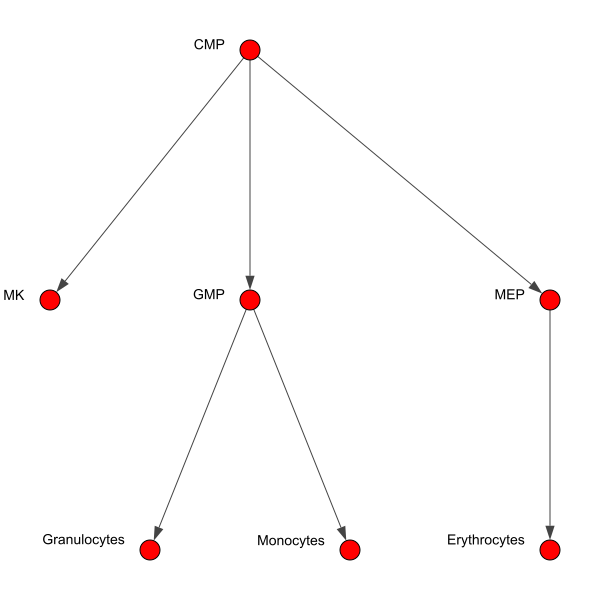

In [8]:
state_path = onesc.construct_cluster_network(train_exp, samp_tab, initial_clusters = initial_clusters, terminal_clusters = end_clusters, cluster_col = cluster_col, pseudo_col = pt_col)
onesc.plot_state_graph(state_path)

In [9]:
lineage_cluster = onesc.extract_trajectory(state_path,initial_clusters, end_clusters)


In [10]:
# find the boolean threshold for each gene
vector_thresh = onesc.find_threshold_vector(train_exp, samp_tab, cluster_col = "cell_types", cutoff_percentage=0.4)

# identify the finner time steps at which genes change along individual trajectory
lineage_time_change_dict = onesc.find_gene_change_trajectory(train_exp, samp_tab, lineage_cluster, cluster_col, pt_col, vector_thresh, pseudoTime_bin=0.01)

In [11]:
# define boolean states profiles for each cell cluster
state_dict = onesc.define_states(train_exp, samp_tab, lineage_cluster, vector_thresh, cluster_col, percent_exp = 0.3)

# save the dictionary of Boolean states into a pickle object.
# we will be needing the Boolean profiles of initial state for running simulations
pickle.dump(state_dict, open("state_dict.pickle", "wb"))

# define transition profiles for each cell clusters
transition_dict = onesc.define_transition(state_dict)

In [12]:
# curate the training data for GRN inference for each gene
training_data = onesc.curate_training_data(state_dict, transition_dict, lineage_time_change_dict, samp_tab, cluster_id = cluster_col, pt_id = pt_col,act_tolerance = 0.04)

# calculate the pearson correlation between genes. This adds more information during the inference step.
corr_mat = onesc.calc_corr(train_exp)
ideal_edge_num = round(0.4 * corr_mat.shape[1])


Cebpe have conflicting states, the below states are deleted
['GMP_unstable_trajectory_1', 'GMP_stable_trajectory_2']
Fli1 have conflicting states, the below states are deleted
['CMP_stable_trajectory_0', 'CMP_stable_trajectory_1', 'CMP_stable_trajectory_2', 'CMP_unstable_trajectory_3']
Gata1 have conflicting states, the below states are deleted
['CMP_unstable_trajectory_0', 'CMP_stable_trajectory_1', 'CMP_stable_trajectory_2', 'CMP_stable_trajectory_3']
Gata2 have conflicting states, the below states are deleted
['CMP_stable_trajectory_0', 'CMP_unstable_trajectory_1', 'CMP_unstable_trajectory_2', 'CMP_stable_trajectory_3']
Sox4 have conflicting states, the below states are deleted
['CMP_stable_trajectory_1', 'CMP_stable_trajectory_2', 'CMP_unstable_trajectory_3']


In [13]:
start_time = time.time()
grn_ensemble = onesc.create_network_ensemble(training_data,
                                            corr_mat,
                                            ideal_edges = ideal_edge_num,
                                            num_generations = 300,
                                            max_iter = 30,
                                            num_parents_mating = 4,
                                            run_parallel = True,
                                            sol_per_pop = 30,
                                            reduce_auto_reg = True,
                                            GA_seed_list = [1, 2, 3, 4, 5],
                                            init_pop_seed_list = [21, 22, 23, 24, 25]) # this would generate 25 networks (one for each GA, init seed combo)

time_lapse = time.time() - start_time

c:\Users\Dan\anaconda3\envs\OneSC_run\lib\site-packages\onesc\genetic_algorithm_GRN.py:845: UserWarning: Maximum number of cores is 12
  warnings.warn("Maximum number of cores is " + str(cpu_count()))
Network inference ensemble (parallelization 12 cores): 100%|██████████| 25/25 [18:26<00:00, 44.25s/it]  


In [14]:
print("OneSC training takes " + str(time_lapse) + " seconds")

OneSC training takes 1106.9079155921936 seconds


In [15]:
inferred_grn = grn_ensemble[0]
print(inferred_grn)

      TF     TG Type
0   Fli1  Cebpa    -
0  Gata1  Cebpa    -
0  Gfi1b  Cebpa    -
0   Klf1  Cebpa    -
0  Zfpm1  Cebpa    -
0  Gata1  Cebpe    -
0  Gata2  Cebpe    -
0   Irf8  Cebpe    -
0   Klf1  Cebpe    -
0  Zfpm1  Cebpe    -
0  Gata1   Fli1    -
0  Gata2   Fli1    +
0  Gfi1b   Fli1    -
0   Klf1   Fli1    -
0   Pbx1   Fli1    +
0  Cebpa  Gata1    -
0   Fli1  Gata1    -
0   Irf8  Gata1    -
0   Klf1  Gata1    +
0  Zfpm1  Gata1    +
0  Cebpa  Gata2    -
0  Cebpe  Gata2    -
0   Irf8  Gata2    -
0   Klf1  Gata2    -
0   Sox4  Gata2    -
0  Cebpa  Gfi1b    -
0   Fli1  Gfi1b    -
0  Gata2  Gfi1b    +
0   Irf8  Gfi1b    -
0   Klf1  Gfi1b    +
0  Cebpe   Irf8    -
0  Gata1   Irf8    -
0  Gata2   Irf8    -
0   Klf1   Irf8    -
0  Zfpm1   Irf8    -
0  Cebpa   Klf1    -
0   Fli1   Klf1    -
0  Gata2   Klf1    +
0  Gfi1b   Klf1    +
0   Irf8   Klf1    -
0  Cebpa  Mef2c    -
0  Gata1  Mef2c    -
0  Gata2  Mef2c    +
0  Gfi1b  Mef2c    -
0   Klf1  Mef2c    -
0  Gata2   Pbx1    +
0   Klf1   Pb

Run Simulation (Method 1)

In [16]:
MyNetwork = onesc.network_structure()
MyNetwork.fit_grn(inferred_grn)
MySimulator = onesc.OneSC_simulator()
MySimulator.add_network_compilation('Myeloid_network', MyNetwork)

In [17]:
# get the Boolean profiles of the initial state 
state_dict = pickle.load(open('state_dict.pickle', 'rb'))
init_state = state_dict['trajectory_0'].iloc[:, 0]
# put them into a dictionary 
init_exp_dict = dict()
for gene in init_state.index: 
    if init_state[gene] == 1:
        init_exp_dict[gene] = 2 # in the fitted grn, 2 is considered as fully turned on 
    else:
        init_exp_dict[gene] = 0

In [18]:
onesc.simulate_parallel(MySimulator, init_exp_dict, 'Myeloid_network', n_cores = 10, output_dir = "sim_profiles", num_runs = 100, num_sim = 1800, t_interval = 0.1, noise_amp = 0.5)